In [1]:
import numpy as np
from video_import import *
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage.filters.thresholding import threshold_otsu
from skimage.segmentation import mark_boundaries
from skimage.exposure import adjust_log
import cv2 
import pandas as pd

# 1. Import data

In [2]:
data = import_avi("../../data/video_1.avi")
# coordinates_file = pd.ExcelFile("xy coordinates for knee imaging 0913.xlsx", engine='openpyxl') # outdated command for my version of xlrd

In [3]:
# More updated Excel import
coordinates_file = pd.read_excel("../../data/xy coordinates for knee imaging 0913.xlsx", engine='openpyxl', sheet_name=None)
coordinates_file.keys()
coordinates = coordinates_file['8.29 3rd']

In [4]:
frames_to_analyze = np.unique(coordinates["Frame Number"])
frames_to_analyze = frames_to_analyze[~np.isnan(frames_to_analyze)]
frames_to_analyze = frames_to_analyze.astype(int)

In [5]:
coordinates["Frame Number"] = np.repeat(frames_to_analyze,4)

In [6]:
coordinates

,Unnamed: 0,Frame Number,Points,X,Y
0,Flexion,577,1,114,386
1,Frame577-618,577,2,272,472
2,608,577,3,397,321
3,extension,577,4,313,605
4,frame 630-669,578,1,114,386
...,...,...,...,...,...
323,NaN,668,4,444,685
324,NaN,669,1,220,528
325,NaN,669,2,405,592
326,NaN,669,3,536,457


# Visualization

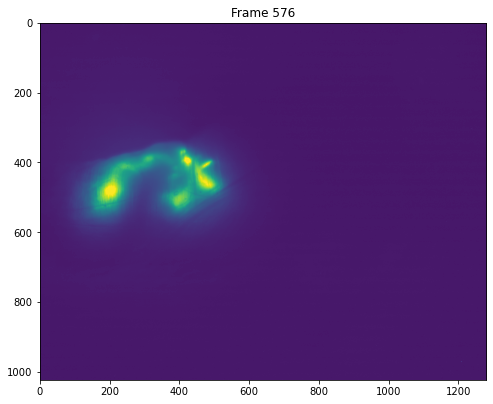

In [7]:
frame_preview = 576#612
frame = data[:,:,:,frame_preview]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8,8))
plt.title(f"Frame {frame_preview}")
plt.imshow(frame)
plt.show()

# Preprocessing

### Gaussian Blur
##### Gets rid of noise and smoothes out edges

In [8]:
sigma = 3
frame_smooth = ndi.gaussian_filter(frame, sigma)

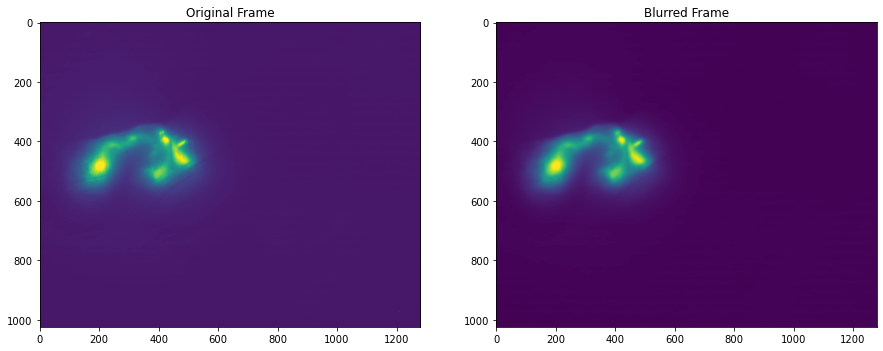

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(frame)
ax[0].set_title("Original Frame")
ax[1].imshow(frame_smooth)
ax[1].set_title("Blurred Frame")
plt.show()

In [10]:
contrasted_image_log = adjust_log(frame_smooth, 1)
#contrasted_image_log = equalize_adapthist(frame_smooth,clip_limit=0.000001)

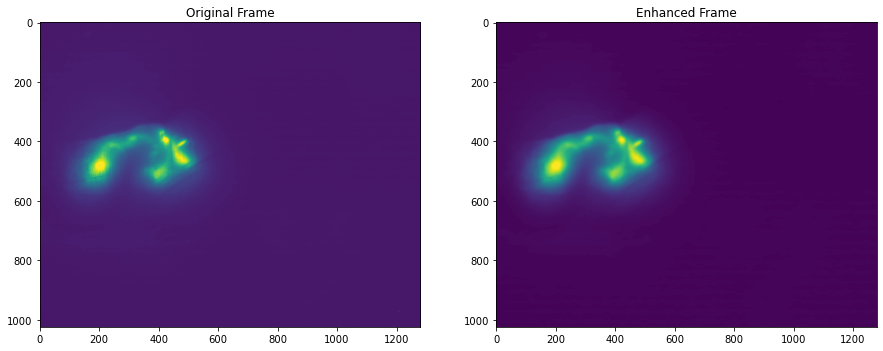

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(frame)
ax[0].set_title("Original Frame")
ax[1].imshow(contrasted_image_log)
ax[1].set_title("Enhanced Frame")
plt.show()

# Segmentation

##### Thresholding

In [12]:
threshold_value_otsu = threshold_otsu(contrasted_image_log)
binary_image_otsu = contrasted_image_log > threshold_value_otsu
binary_image_otsu = binary_image_otsu.astype(int)

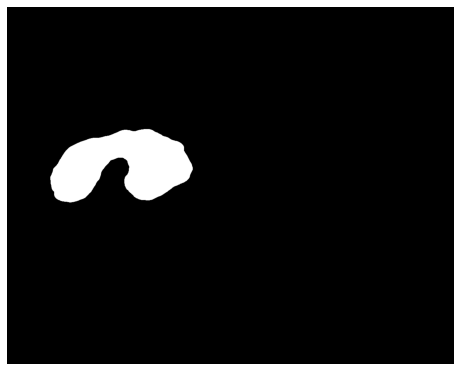

In [13]:
fig = plt.figure(figsize=(8,8))
plt.imshow(binary_image_otsu, cmap="gray")
plt.axis("off")
plt.show()

# 3 points

In [14]:
points = coordinates[coordinates["Frame Number"] == frame_preview+1][['Points',"X","Y"]]

In [15]:
point1 = (round(points[points["Points"]==1]["X"].iloc[0]), round(points[points["Points"]==1]["Y"].iloc[0]))
point2 = (round(points[points["Points"]==2]["X"].iloc[0]), round(points[points["Points"]==2]["Y"].iloc[0]))
point3 = (round(points[points["Points"]==3]["X"].iloc[0]), round(points[points["Points"]==3]["Y"].iloc[0]))
point4 = (round(points[points["Points"]==4]["X"].iloc[0]), round(points[points["Points"]==4]["Y"].iloc[0]))
line1 = [[point1[0], point2[0]], [point1[1], point2[1]]]
line2 = [[point3[0], point4[0]], [point3[1], point4[1]]]
mask = np.zeros((binary_image_otsu.shape[0],binary_image_otsu.shape[1]))

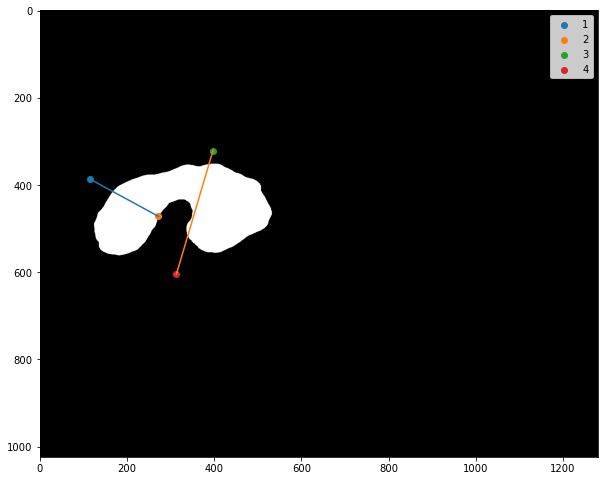

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(binary_image_otsu, cmap="gray")
plt.scatter(point1[0], point1[1], label="1")
plt.scatter(point2[0], point2[1], label="2")
plt.scatter(point3[0], point3[1], label="3")
plt.scatter(point4[0], point4[1], label="4")
plt.plot(line1[0], line1[1])
plt.plot(line2[0], line2[1])
plt.legend()
plt.show()

In [17]:
def newLine(p1, p2):
    m = (p1[1]-p2[1])/(p1[0]-p2[0])
    b = p1[1] - m*p1[0]
    return m,b


In [18]:
m1,b1 = newLine(point1,point2)
m2,b2 = newLine(point3,point4)

critical_x1_points = [max(round(-b1/m1), 0), min(round((binary_image_otsu.shape[0]-b1)/m1), binary_image_otsu.shape[1])]
critical_x2_points = [max(round(-b2/m2), 0), min(round((binary_image_otsu.shape[0]-b2)/m2), binary_image_otsu.shape[1])]

critical_x1_min = min(critical_x1_points)
critical_x1_max = max(critical_x1_points)
critical_x2_min = min(critical_x2_points)
critical_x2_max = max(critical_x2_points)

if critical_x1_min > 0:
    critical_x1_min = 0
if critical_x1_max >= binary_image_otsu.shape[1]:
    critical_x1_max = binary_image_otsu.shape[1]-1
if critical_x2_min < 0:
    critical_x2_min = 0
if critical_x2_max <= binary_image_otsu.shape[1]:
    critical_x2_max = binary_image_otsu.shape[1]-1
if m1>=0:
    for x in range(critical_x1_min, critical_x1_max+1):
        y = m1*x+b1
        y = round(y)
        if y>=0:
            mask[y:,x] = 2
        else:
            mask[:,x] = 2
else:
    for x in range(critical_x1_min, critical_x1_max+1):
        y = m1*x+b1
        y = round(y)
        mask[:y,x] = 2


if m2<=0:
    for x in range(critical_x2_min, critical_x2_max+1):
        y = m2*x+b2
        y = round(y)
        if y>=0:
            mask[y:,x] = 3
        else:
            mask[:,x] = 3
else:
    for x in range(critical_x2_min, critical_x2_max+1):
        y = m2*x+b2
        y = round(y)
        if y>=0:
            mask[:y,x] = 3

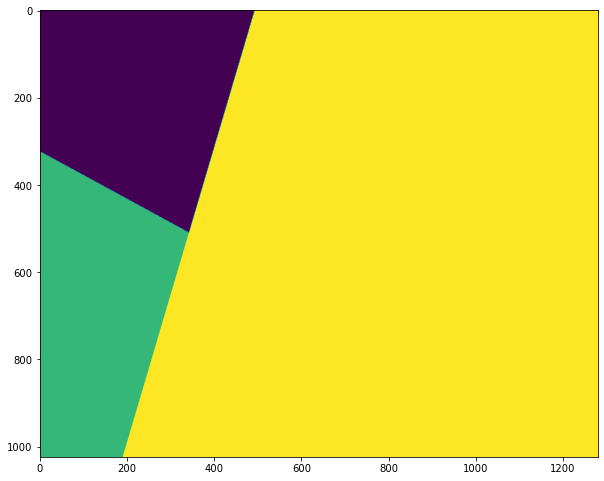

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

In [20]:
binary_image_otsu[(binary_image_otsu==1) & (mask==2)] = 2
binary_image_otsu[(binary_image_otsu==1) & (mask==3)] = 3

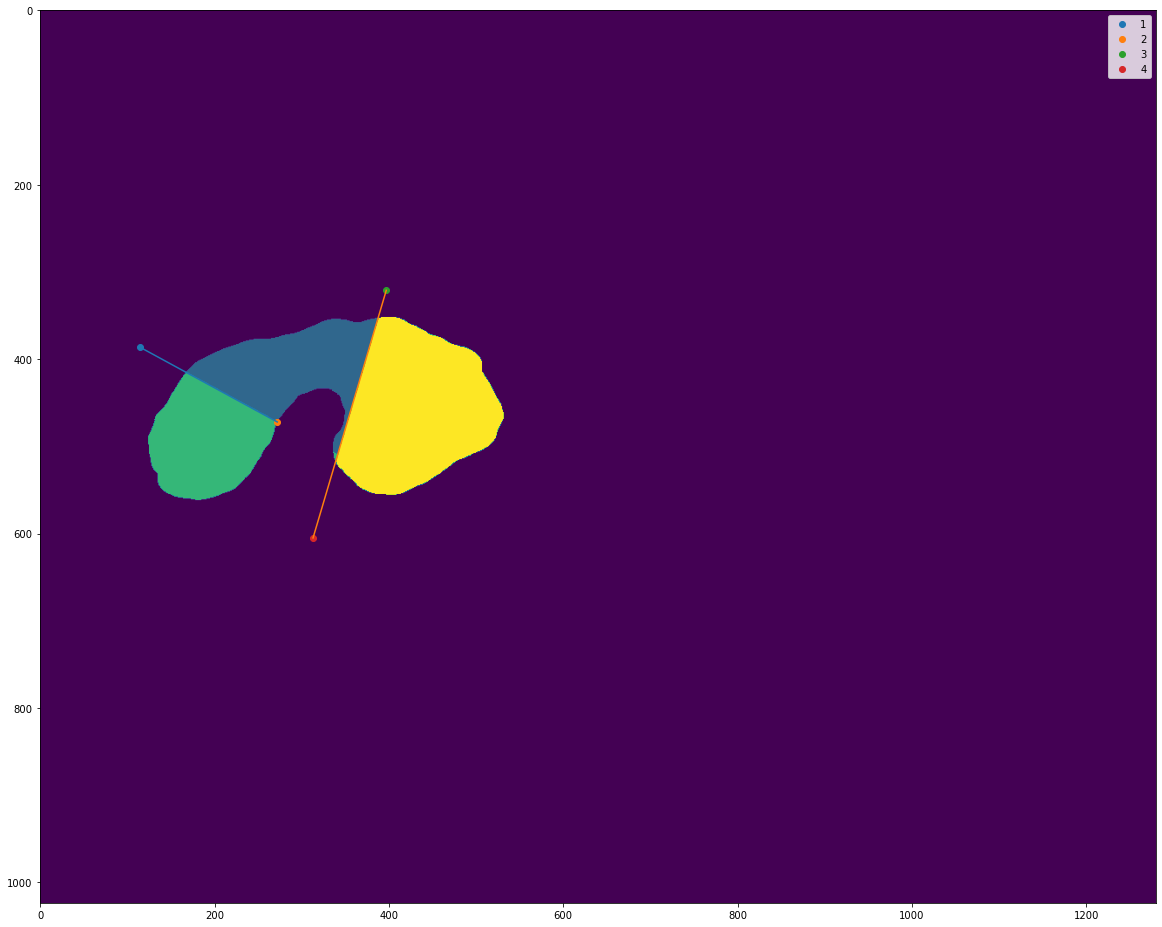

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(binary_image_otsu)
plt.scatter(point1[0], point1[1], label="1")
plt.scatter(point2[0], point2[1], label="2")
plt.scatter(point3[0], point3[1], label="3")
plt.scatter(point4[0], point4[1], label="4")
plt.plot(line1[0], line1[1])
plt.plot(line2[0], line2[1])
plt.legend()
plt.show()

##### Cleaning

In [22]:
left_labels_x_indices = np.unique(np.where(binary_image_otsu == 2)[1])
if len(np.where(np.append(left_labels_x_indices[1:],left_labels_x_indices[-1]+1) - left_labels_x_indices !=1)[0])>0:
    starting_index_to_separate = np.where(np.append(left_labels_x_indices[1:],left_labels_x_indices[-1]+1) - left_labels_x_indices !=1)[0][0] + 1
    indices_that_are_not_left = left_labels_x_indices[starting_index_to_separate:]
    for i in range(indices_that_are_not_left[0], indices_that_are_not_left[-1]+1):
        for j in range(binary_image_otsu.shape[0]):
            if binary_image_otsu[j,i] == 2:
                binary_image_otsu[j,i] = 1

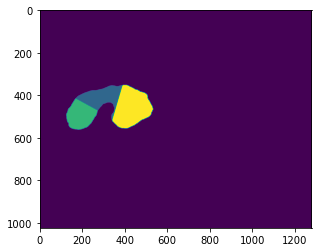

In [23]:
plt.imshow(binary_image_otsu)
plt.show()

##### Boundary Detection

In [24]:
m = mark_boundaries(frame, binary_image_otsu)

In [25]:
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

In [26]:
show_frame = np.copy(frame)
show_frame[np.all(m==[1,1,0], axis=2)] = [255,255,0]

(-0.5, 1279.5, 1023.5, -0.5)

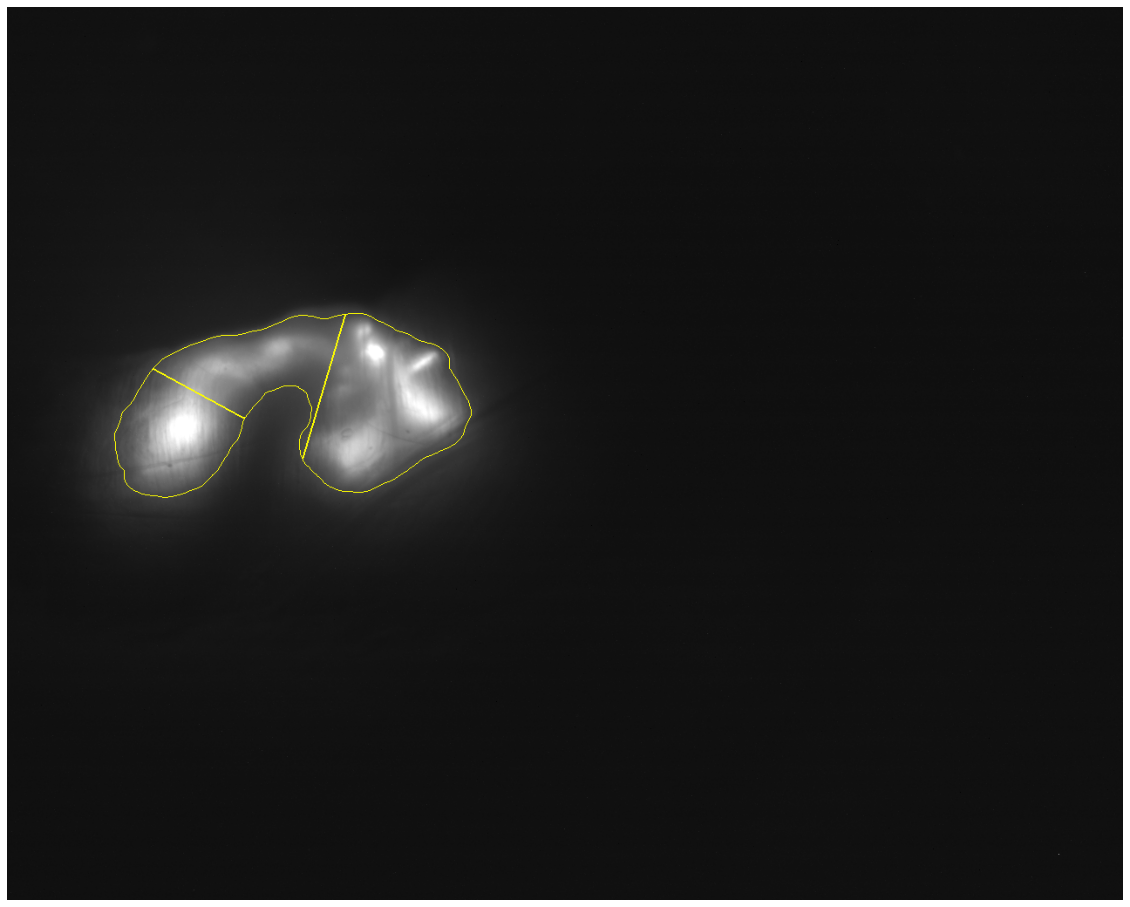

In [27]:
fig = plt.figure(figsize=(20,20))
plt.imshow(show_frame, cmap="gray")
plt.axis("off")

In [28]:
# Make boudnaries bigger
show_frame_scaled = np.copy(show_frame)
scaling = 3
boundaries = np.where(np.all(show_frame_scaled==[255,255,0], axis=2))
for i in range(len(boundaries[0])):
    x = boundaries[0][i]
    y = boundaries[1][i]

    for j in range(1,scaling+1):
        # top
        show_frame_scaled[x,y+1*j,:] = [255,255,0]
        # bottom
        show_frame_scaled[x,y-1*j,:] = [255,255,0]
        # right
        show_frame_scaled[x+1*j,y,:] = [255,255,0]
        # left
        show_frame_scaled[x-1*j,y,:] = [255,255,0]
        # top_right
        show_frame_scaled[x+1*j,y+1*j,:] = [255,255,0]
        # top_left
        show_frame_scaled[x-1*j,y+1*j,:] = [255,255,0]
        # bottom_right
        show_frame_scaled[x+1*j,y-1*j,:] = [255,255,0]
        # bottom_left
        show_frame_scaled[x-1*j,y-1*j,:] = [255,255,0]

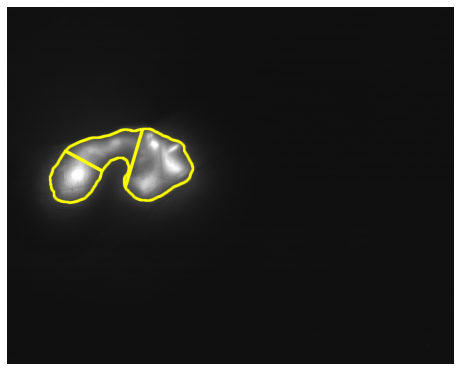

In [29]:
fig = plt.figure(figsize=(8,8))
plt.imshow(show_frame_scaled, cmap="gray")
plt.axis("off")
plt.show()

# Average of three parts

In [30]:
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

In [31]:
left_part_mean = np.mean(frame[binary_image_otsu == 2])
middle_part_mean = np.mean(frame[binary_image_otsu == 1])
right_part_mean = np.mean(frame[binary_image_otsu == 3])

In [32]:
print(left_part_mean)
print(left_part_mean.shape)

135.46669471322394
